# Cyclone detection by satellite data

Cyclones are the large scale intense circular storm that originates over warm tropical oceans and is characterized by low atmospheric pressure, high winds, and heavy rain.
Variously referred as hurricane or typhoon, cyclone has a significant socio-economic impact.
The accurate forecast of the cyclone track has been a significant achievement of modern meteorology. 
Aided by the development of satellites and improved computational power, cyclone predictability has improved over the years.
Recently with the advent of machine learning few attempts have been made to understand the cyclone.
In this notebook I have tried to detect the presence of cyclone using the reanalysis data.

### Data

Atlantic basin is selected for the analysis. List of cyclonic disturbances can be found here (https://www.kaggle.com/noaa/hurricane-database) and (https://www.nhc.noaa.gov/data/).
For the present analysis I have considered all the disturbances regardless of its strength as cyclone.
Vorticity and geopotential height at 500 hPa level as well as mean sea level pressure and cloud cover are used as predictors. [ERA_Interim](https://apps.ecmwf.int/datasets/data/interim-full-daily/levtype=sfc/) 4X daily data at a resolution of 0.75 deg is used. 
Data from the years 1970-2015 is used.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import keras
import xarray
plt.ion()

Using TensorFlow backend.


In [2]:
data = pd.read_csv('/home/suhas/Desktop/DeepWeather/Data/cyclone/atlantic_hurricane_kaggle.csv', sep=',')
hours = [0,600,1200,1800]
data = data[data['Time'].isin(hours)]
time = pd.to_datetime(data['Date'], format='%Y%m%d')+ pd.to_timedelta(data['Time']/100, unit='h')
time = time[(time.dt.year >= 1979) & (time.dt.year <= 2015)]
data.tail()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
49100,AL122015,KATE,20151112,1200,,EX,41.3N,50.4W,55,981,...,180,120,120,120,60,0,0,0,0,0
49101,AL122015,KATE,20151112,1800,,EX,41.9N,49.9W,55,983,...,180,120,120,120,60,0,0,0,0,0
49102,AL122015,KATE,20151113,0,,EX,41.5N,49.2W,50,985,...,200,220,120,120,60,0,0,0,0,0
49103,AL122015,KATE,20151113,600,,EX,40.8N,47.5W,45,985,...,180,220,0,0,0,0,0,0,0,0
49104,AL122015,KATE,20151113,1200,,EX,40.7N,45.4W,45,987,...,150,220,0,0,0,0,0,0,0,0


6 hour time stamps are generated between 1970-2015. 
If the cyclonic activites are present cyclone_label is assigned 1 else 0.

In [3]:
time_new = pd.date_range(start='1/1/1979', end='1/1/2016', freq='6h')
time_new = time_new[0:-1]
cyclone_label = np.zeros(len(time_new))
cyclone_label[time_new.isin(time)] = 1
cyclone_label = cyclone_label.astype(int)

Read reanalysis data.

In [4]:
def extractData(filePath,var, yearMin, yearMax):
    data = xarray.open_dataset(filePath)
    out  = data[var]
    tm  = data.time.dt.year   
    out  = out[(tm >= yearMin) & (tm <= yearMax)]
    out  = (out - np.mean(out))/np.std(out)
    data.close()
    return out

In [5]:
pr    = extractData('Data/cyclone/era_surface.nc', 'msl', 1979, 2015)
cloud = extractData('Data/cyclone/era_surface.nc', 'tcc', 1979, 2015)
vrt   = extractData('Data/cyclone/era_500.nc', 'vo', 1979, 2015)
geopt = extractData('Data/cyclone/era_500.nc', 'z', 1979, 2015)

Only about 20% of the times experience cyclonic activities. This uneven distribution of data could result in incorrect classification. So equal number of cyclonic and nornmal times are considered.

In [6]:
print ("Ratio of cyclonic activity :", np.sum(cyclone_label)/len(cyclone_label))

Ratio of cyclonic activity : 0.2093014651472547


In [7]:
np.random.seed(23)
idx = np.arange(len(cyclone_label))
idx1 = idx[cyclone_label == 1]
idx2 = idx[cyclone_label == 0]
idx2 = np.random.choice(idx2, size=len(idx1), replace=False)
idx = np.concatenate((idx1,idx2))
idx = np.sort(idx)

Training, validation and test data are split in the ratio of 60%, 20% and 20% respectively. 
Succesive times will have a significant correlation. So disfferent years are considered for training, validation and test split.

In [8]:
X = np.stack((vrt,geopt,cloud,pr),axis=3)
X = X[idx]
Y = cyclone_label[idx]

ntotal = len(Y)
ntrain = int(0.6*ntotal)
nval   = int(0.2*ntotal)
ntest  = ntotal - ntrain - nval
trainIdx = np.random.permutation(ntrain)
valIdx   = np.random.permutation(nval) + ntrain
testIdx  = np.random.permutation(ntest) + ntrain + nval

X_train = X[trainIdx]
Y_train = Y[trainIdx]
X_val   = X[valIdx]
Y_val   = Y[valIdx]
X_test  = X[testIdx]
Y_test  = Y[testIdx]

print ("X_train shape:", X_train.shape)
print ("X_val  shape:", X_val.shape)
print ("X_test shape:", X_test.shape)

X_train shape: (13576, 54, 121, 4)
X_val  shape: (4525, 54, 121, 4)
X_test shape: (4527, 54, 121, 4)


In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same',
                        input_shape=(X.shape[1], X.shape[2], X.shape[3])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, batch_size=128, validation_data=(X_val,Y_val))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 121, 8)        296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 60, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 60, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 30, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 30, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxP

(1, 10)

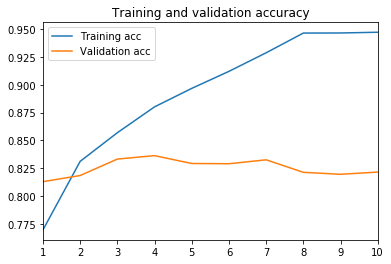

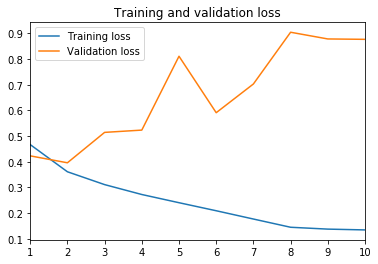

In [10]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(len(acc)) + 1

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlim(1,10)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlim(1,10)

Now let us train the model with all the data (training + validation) set. n_epochs is set to 4 as validation accuracy decreases and loss increases after that.


In [12]:
X = np.stack((vrt,geopt,cloud,pr),axis=3)
X = X[idx]
Y = cyclone_label[idx]

ntotal = len(Y)
ntrain = int(0.6*ntotal)
nval   = int(0.2*ntotal)
ntest  = ntotal - ntrain - nval
trainIdx = np.random.permutation(ntrain)
valIdx   = np.random.permutation(nval) + ntrain
testIdx  = np.random.permutation(ntest) + ntrain + nval
trainIdx = np.append(trainIdx,valIdx) # use both training and validation data

X_train = X[trainIdx]
Y_train = Y[trainIdx]
X_test  = X[testIdx]
Y_test  = Y[testIdx]

print ("X_train shape:", X_train.shape)
print ("X_test shape:", X_test.shape)

X_train shape: (18101, 54, 121, 4)
X_test shape: (4527, 54, 121, 4)


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same',
                        input_shape=(X.shape[1], X.shape[2], X.shape[3])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=4, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 54, 121, 8)        296       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 27, 60, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 60, 16)        1168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 30, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 30, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 15, 32)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 15, 64)         18496     
__________

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print ("Test Loss:", loss)
print ("Test Accuracy:", accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict_classes(X_test)
cmat =  confusion_matrix(Y_test,Y_pred)
cmat
seaborn.heatmap(cmat, annot=True,fmt='g')

Test accuracy is about 84-85%. Model seems to be perfoming fairly good. 
Further inclusion of additional parameters would perhaps lead to 
Recently some work have been done in identifying the eye of the cyclone as well as its intensity.
In coming years a significant improvement in understanding and forecasting of cyclones would be possible duw to machine learning.